### ***Step 0: Upload dataset***

In [1]:
from google.colab import files
import pandas as pd

# Upload your CSV
uploaded = files.upload()

# Replace with your uploaded filename
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name, low_memory=False)

print("Dataset loaded:", df.shape)
df.head(3)


Saving dex-temp-db.score_v4.csv to dex-temp-db.score_v4.csv
Dataset loaded: (44975, 396)


,_id,wallet_id,lp_scores[0].pool_id,lp_scores[1].pool_id,lp_scores[2].pool_id,lp_scores[3].pool_id,lp_scores[4].pool_id,lp_scores[5].pool_id,lp_scores[6].pool_id,lp_scores[7].pool_id,...,lp_scores[7].last_tx_timestamp,lp_scores[8].last_tx_timestamp,lp_scores[9].last_tx_timestamp,lp_scores[10].last_tx_timestamp,lp_scores[11].last_tx_timestamp,lp_scores[12].last_tx_timestamp,aggregated_lp_score,lp_category_breakdown.stable-stable,lp_category_breakdown.stable-volatile,lp_category_breakdown.volatile-volatile
0,6874b820a794db5e6c4c2dbf,0x0057d4a850e34bac84ed297f14ba146747b90272,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,147.00,0.0,147.0,0.000000
1,6874b820a794db5e6c4c2dc8,0x00819eb70be2aecee2915ed76f9bb6ca2cfbd390,0x4ccd010148379ea531d6c587cfdd60180196f9b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,52.00,0.0,52.0,0.000000
2,6874b821a794db5e6c4c2dee,0x00d4c206ae699d5d2bf19a542a544276dc50889c,0x167384319b41f7094e62f7506409eb38079abff8,0x50eaedb835021e4a108b7290636d62e9765cc6d7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,296.56,0.0,0.0,348.895306


### ***Step 1: Basic exploration***


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44975 entries, 0 to 44974
Columns: 396 entries, _id to lp_category_breakdown.volatile-volatile
dtypes: float64(303), int64(13), object(80)
memory usage: 135.9+ MB
None
       lp_scores[0].fee_tier  lp_scores[1].fee_tier  lp_scores[2].fee_tier  \
count           44975.000000            8638.000000            1899.000000   
mean                0.002218               0.002008               0.002079   
std                 0.002131               0.002786               0.003059   
min                 0.000100               0.000100               0.000100   
25%                 0.000500               0.000500               0.000500   
50%                 0.003000               0.000500               0.000500   
75%                 0.003000               0.003000               0.003000   
max                 0.010000               0.010000               0.010000   

       lp_scores[3].fee_tier  lp_scores[4].fee_tier  lp_scores[5].fee_tier  \
c

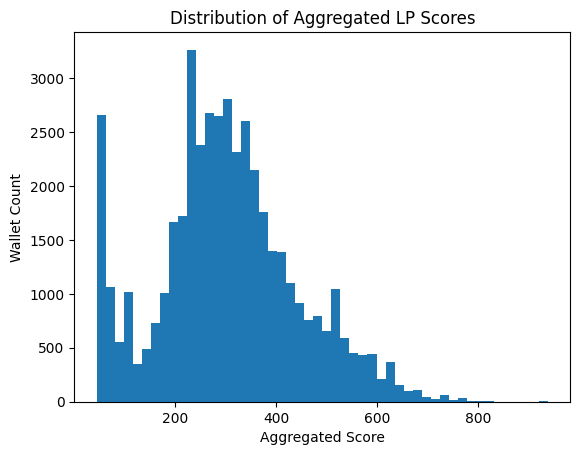

In [2]:
print(df.info())
print(df.describe())

# Distribution of aggregated LP scores
import matplotlib.pyplot as plt

plt.hist(df["aggregated_lp_score"], bins=50)
plt.title("Distribution of Aggregated LP Scores")
plt.xlabel("Aggregated Score")
plt.ylabel("Wallet Count")
plt.show()


### ***Step 2: Check if aggregated_lp_score matches sum of pool scores***

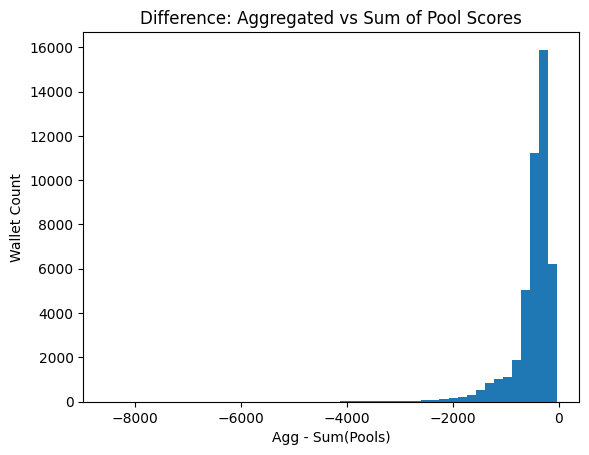

Exact matches: 0.00%


In [3]:
# Find all per-pool total score columns
pool_score_cols = [c for c in df.columns if c.endswith(".total_score")]

# Sum across pools
df["sum_pool_scores"] = df[pool_score_cols].sum(axis=1, skipna=True)

# Compare with aggregated score
df["score_diff"] = df["aggregated_lp_score"] - df["sum_pool_scores"]

plt.hist(df["score_diff"], bins=50)
plt.title("Difference: Aggregated vs Sum of Pool Scores")
plt.xlabel("Agg - Sum(Pools)")
plt.ylabel("Wallet Count")
plt.show()

exact_match = (df["score_diff"].abs() < 1e-6).mean() * 100
print(f"Exact matches: {exact_match:.2f}%")


Extending Step 2 so I can go beyond “0% exact matches” and try to discover the hidden relationship between aggregated_lp_score and the sum of per-pool scores.

Exact matches (%): 0.0
Mean difference: -482.43549727626464
Median difference: -378.35


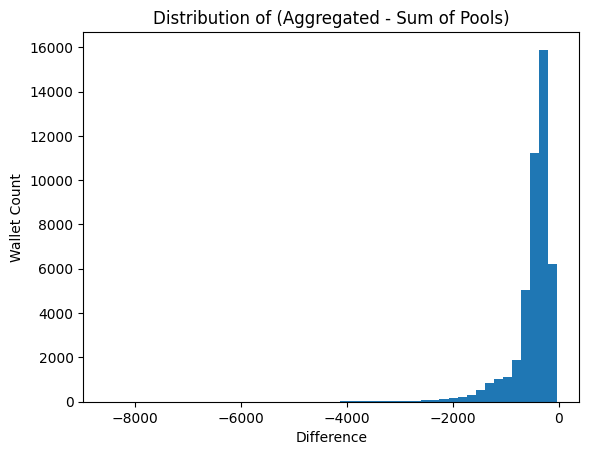

Correlation between aggregated and sum of pools: 0.6345904298552665


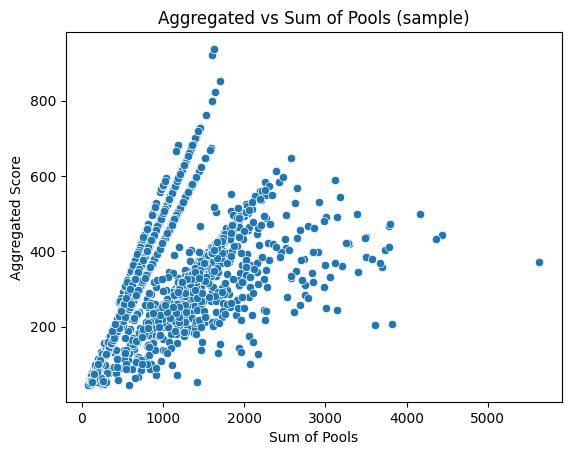

Regression fit:
  Coefficient (scaling factor): 0.1806
  Intercept (offset): 161.4338
  R² score: 0.4027


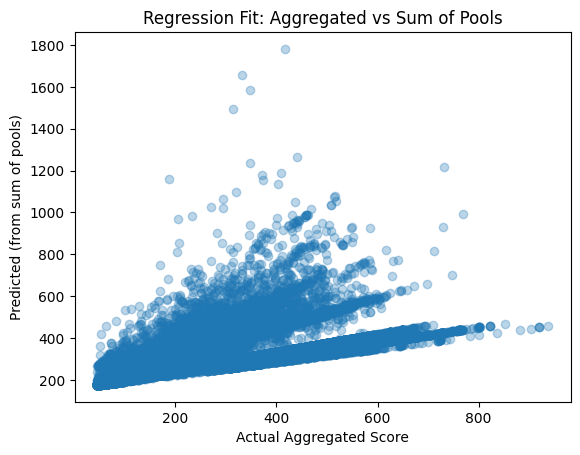

Correlation with average pool score: 0.9648123053743789


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Step 2.1: Compare direct sum
pool_score_cols = [c for c in df.columns if c.endswith(".total_score")]
df["sum_pool_scores"] = df[pool_score_cols].sum(axis=1, skipna=True)

df["score_diff"] = df["aggregated_lp_score"] - df["sum_pool_scores"]

print("Exact matches (%):", (df["score_diff"].abs() < 1e-6).mean() * 100)
print("Mean difference:", df["score_diff"].mean())
print("Median difference:", df["score_diff"].median())

plt.hist(df["score_diff"], bins=50)
plt.title("Distribution of (Aggregated - Sum of Pools)")
plt.xlabel("Difference")
plt.ylabel("Wallet Count")
plt.show()

# Step 2.2: Correlation check
corr = df["aggregated_lp_score"].corr(df["sum_pool_scores"])
print("Correlation between aggregated and sum of pools:", corr)

sns.scatterplot(x="sum_pool_scores", y="aggregated_lp_score", data=df.sample(5000))
plt.title("Aggregated vs Sum of Pools (sample)")
plt.xlabel("Sum of Pools")
plt.ylabel("Aggregated Score")
plt.show()

# Step 2.3: Linear regression (is there a scaling/offset?)
X = df["sum_pool_scores"].fillna(0).values.reshape(-1, 1)
y = df["aggregated_lp_score"].fillna(0).values

model = LinearRegression()
model.fit(X, y)

print("Regression fit:")
print(f"  Coefficient (scaling factor): {model.coef_[0]:.4f}")
print(f"  Intercept (offset): {model.intercept_:.4f}")
print(f"  R² score: {model.score(X, y):.4f}")

# Predicted vs actual
df["predicted_agg"] = model.predict(X)
plt.scatter(df["aggregated_lp_score"], df["predicted_agg"], alpha=0.3)
plt.xlabel("Actual Aggregated Score")
plt.ylabel("Predicted (from sum of pools)")
plt.title("Regression Fit: Aggregated vs Sum of Pools")
plt.show()

# Step 2.4: Test normalization by pool count
# (Sometimes aggregated score is average or weighted)
df["num_pools"] = df[pool_score_cols].notnull().sum(axis=1)

df["avg_pool_score"] = df["sum_pool_scores"] / df["num_pools"].replace(0, np.nan)
corr_avg = df["aggregated_lp_score"].corr(df["avg_pool_score"])

print("Correlation with average pool score:", corr_avg)


### ***Step 3: Do category breakdowns sum up to aggregated_lp_score?***

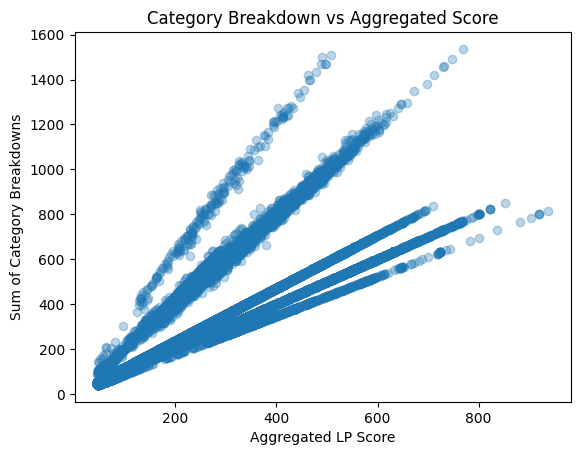

In [4]:
df["sum_breakdowns"] = (
    df["lp_category_breakdown.stable-stable"].fillna(0)
    + df["lp_category_breakdown.stable-volatile"].fillna(0)
    + df["lp_category_breakdown.volatile-volatile"].fillna(0)
)

plt.scatter(df["aggregated_lp_score"], df["sum_breakdowns"], alpha=0.3)
plt.xlabel("Aggregated LP Score")
plt.ylabel("Sum of Category Breakdowns")
plt.title("Category Breakdown vs Aggregated Score")
plt.show()


### ***Step 4: Cohort analysis (deposit deciles vs score)***

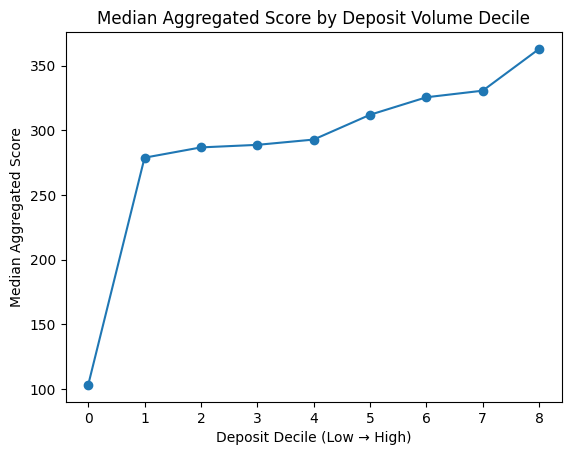

In [5]:
# Sum total deposits across pools
deposit_cols = [c for c in df.columns if "total_deposit_all_time" in c]
df["total_deposit_all_time"] = df[deposit_cols].sum(axis=1, skipna=True)

# Group into deciles
df["deposit_decile"] = pd.qcut(df["total_deposit_all_time"], 10, labels=False, duplicates="drop")
cohort = df.groupby("deposit_decile")["aggregated_lp_score"].median()

cohort.plot(kind="line", marker="o")
plt.title("Median Aggregated Score by Deposit Volume Decile")
plt.xlabel("Deposit Decile (Low → High)")
plt.ylabel("Median Aggregated Score")
plt.show()


### ***Step 5: Which score components drive the pool total_score?***

In [6]:
# Example: First pool’s score breakdown
component_cols = [c for c in df.columns if "lp_scores[0].score_breakdown" in c and not c.endswith("total_score")]

for col in component_cols:
    corr = df[col].corr(df["lp_scores[0].score_breakdown.total_score"])
    print(f"Correlation {col}: {corr:.3f}")


Correlation lp_scores[0].score_breakdown.deposit_volume_score: 0.562
Correlation lp_scores[0].score_breakdown.deposit_frequency_score: -0.133
Correlation lp_scores[0].score_breakdown.withdraw_volume_score: 0.694
Correlation lp_scores[0].score_breakdown.avg_holding_time_score: 0.659
Correlation lp_scores[0].score_breakdown.liquidity_retention_score: 0.632
Correlation lp_scores[0].score_breakdown.time_score: 0.145
Correlation lp_scores[0].score_breakdown.lp_volatility_score: 0.414


### ***Step 6: Detect outliers based on score efficiency***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
# Score per $ deposited
df["score_per_dollar"] = df["aggregated_lp_score"] / (df["total_deposit_all_time"] + 1)

# Outlier detection (IQR method)
Q1, Q3 = df["score_per_dollar"].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

outliers = df[(df["score_per_dollar"] < lower) | (df["score_per_dollar"] > upper)]

print("Number of outliers:", len(outliers))
outliers[["wallet_id", "aggregated_lp_score", "total_deposit_all_time", "score_per_dollar"]].head(10)


Number of outliers: 7032


,wallet_id,aggregated_lp_score,total_deposit_all_time,score_per_dollar
1,0x00819eb70be2aecee2915ed76f9bb6ca2cfbd390,52.00,0.000000,52.000000
5,0x0077a0eae57c0e6d73acd6ddff0205995687ccd6,496.00,104.346675,4.708264
21,0x004e926e200f6761934b0377e490a5b974ca3788,477.00,112.290480,4.210416
25,0x00e3c0917baa75e7ab5f3be9ef739d07f45b7dd4,362.00,142.709977,2.518962
27,0x00b62582ca285c4234a36218281eaf88eda9cfc5,50.00,0.000000,50.000000
34,0x0031ec7d6aaf891a4427c39c0863db6b7d5b8e3d,56.00,0.000000,56.000000
35,0x011131c3d5ef8308ec3eab15f7c1863c69f4a4c3,56.00,0.000000,56.000000
36,0x01de494230b03989f9a2d8956fdfe5486d712ebf,65.55,0.000000,65.550000
37,0x001795aefa853c2b0a30cd0a43885695a6cdbd7d,512.00,185.119686,2.750918
38,0x00dde8eed75884f3793bf49b40df36488d5fef2f,59.80,0.000000,59.800000


### ***Save results for report***

In [8]:
# Save anomalies
outliers[["wallet_id", "aggregated_lp_score", "total_deposit_all_time", "score_per_dollar"]].to_csv("anomalies.csv", index=False)

# Save processed dataset with new columns
df.to_csv("processed_lp_scores.csv", index=False)

print("✅ Saved anomalies.csv and processed_lp_scores.csv")


✅ Saved anomalies.csv and processed_lp_scores.csv
